<span style="color: red; font-family: Calibri Light;">
  <h1><b>Topic Modelling with LDA:</b></h1>
    <p style = "color: black"> Using LDA model on pre-processed data. Stop word removal during pre-processing is limited only to common english stop words.<br>Any further stop word removal will be done when creating bag of words with the gensim library 
</span>

---

<span style="color: red; font-family: Calibri Light;">
  <h2><b>I. Setting Up Environment</b></h2>
</span>

In [1]:
#pre-processing libraries

import re #regular expressions library for text manipulation
import string
import unicodedata
import itertools
from autocorrect import Speller
import emoji
import contractions

#data transformation libraries
import pandas as pd
import numpy as np
import ast
import csv

#NLP specific libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.lang.en import English
import spacymoji
from gensim.models import Word2Vec, TfidfModel

#topic modelling libraries
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel, LdaMulticore


#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import pyLDAvis
import pyLDAvis.gensim_models

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#others
import time
import os
import random
from glob import glob
import pickle


In [3]:
#additional nlp models
#!python -m spacy download en_core_web_md

In [15]:
#set seed so that code output is deterministic
random.seed(800)  # Set the seed for Python's random module
np.random.seed(800)  # Set the seed for NumPy's random module

---

<span style="color: red; font-family: Calibri Light;">
  <h2><b>II. Import Data into DataFrame</b></h2>
</span>

In [4]:
def clean_comments (filepath):
    """
    import comments from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `isSubmitter`,
    
    remove duplicates, etc
    
    """
    #import data
    df = pd.read_csv(filepath, low_memory = False)
    
    #remove deleted comments if any
    df = df[df.Body != '[deleted]']
    df = df[df.Body != '[removed]']
    df = df.dropna(subset=['Body'])
    
    #remove comments with missing id
    drop_index = df[df.isSubmitter.isnull()].index
    df.drop(drop_index, inplace = True)
    
    #remove duplicates if any
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #correct data types and column label
    df['Date_Created'] = pd.to_datetime(df['Date_Created'])
    df['year'] = df['Date_Created'].dt.year
    df['Score'] = df['Score'].astype('int') 
    df.rename(columns = {'Author_ID': "Author"}, inplace = True) 
    
    #rename 'Body' column to text
    df.rename(columns = {'Body': 'long_text',
                        'Date_Created': 'date_created'}, inplace = True)
    
    #remove unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'Author', 'Score',
       'Parent_ID', 'Submission_ID', 'Subreddit', 'isParent', 'isSubmitter'], inplace = True)
    
    #remove any extra whitespace in column labels
    df.columns = df.columns.str.strip()
    
    #include column to denote row is comment entry
    df['text_type'] = 'comment'
    
    #rearrange column order
    df = df[['text_type','ID','date_created', 'year', 'long_text']]
        
    return df

def clean_submissions(filepath):
    """
    import submissions/posts from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `Unnamed`,
    
    remove duplicates, etc
    
    """
    df = pd.read_csv(filepath, low_memory = False)
    
    #drop duplicate posts
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #create column for post title + post text
    df['long_text'] = df['Title']+ " " +df['Post Text'].fillna('')
    
    #adjust data types
    df['Date Created'] = pd.to_datetime(df['Date Created'])
    df['year'] = df['year'].astype('int')
    
    #rename columns
    df.rename(columns = {'Date Created': 'date_created'}, inplace = True)
    
    #remove unwanted columns
    df = df.drop(columns = ['Unnamed: 0', 'Title','Post Text', 'Score',
       'Total Comments', 'Post URL', 'SubReddit','Unnamed: 0.1'])
    
    #include column to denote row is comment entry
    df['text_type'] = 'submission'
    
    #reorder columns - 'ID', 'Post Text'
    df  = df[['text_type','ID', 'date_created','year', 'long_text']]
    
    return df  

In [6]:
# Access dataset files
folder_path = os.path.join("..","..", "..", "Data") 
file_type = "*.csv"

# List of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../../../Data/subset_sample_no_label.csv',
 '../../../Data/filtered_corpus.csv',
 '../../../Data/full_posts.csv',
 '../../../Data/full_data_no_preprocessing.csv',
 '../../../Data/training_data.csv',
 '../../../Data/lda_train.csv',
 '../../../Data/vocabulary.csv',
 '../../../Data/emoji_subset.csv',
 '../../../Data/sampled_subset.csv',
 '../../../Data/subs_topics.csv',
 '../../../Data/comments.csv']

In [7]:
comments_filepath = '' #file path for csv file of scraped comments 
submissions_filepath = '' #file path for csv file of scrapped submissions

for path in document_path:
    if "comments" in path:
        comments_filepath = comments_filepath + path
    elif "full_posts" in path:
        submissions_filepath = submissions_filepath + path
    

In [8]:
print (comments_filepath, submissions_filepath)

../../../Data/comments.csv ../../../Data/full_posts.csv


In [9]:
data = pd.concat([clean_comments(comments_filepath), 
                  clean_submissions(submissions_filepath)], 
                 ignore_index = True)

data

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅
...,...,...,...,...,...
128878,submission,14f46ji,2023-06-21 14:40:54,2023,"Best beauty saloons in Dubai? Hello fellas, I ..."
128879,submission,14f4uyi,2023-06-21 15:15:27,2023,Found the r/dubai redditors who kept telling m...
128880,submission,14f4ri3,2023-06-21 15:10:25,2023,Scam ? Healthy.line My sister has a CBD debit ...
128881,submission,14f4k3r,2023-06-21 15:00:34,2023,Thoughts on Expo City properties? Anyone else ...


<span style="color: red; font-family: Calibri Light;">
  <h2><b>III. Text Preprocessing</b></h2>
</span>

<span style="color: red; font-family: Calibri Light;">
  <h3><b>a. convert text to lowercase</b></h3>
</span>

In [10]:
data['clean_text'] = data['long_text'].apply(lambda text: text.lower())

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
121307,comment,ehhmwph,2019-02-28 21:50:39,2019,"It's great to see, but we all know this wouldn...","it's great to see, but we all know this wouldn..."
42971,comment,gmxbwez,2021-02-11 14:51:17,2021,What dose court has to do with ittttt😂,what dose court has to do with ittttt😂
72430,comment,gd10yji,2020-11-21 11:57:13,2020,Karama park used to be a hive of social activi...,karama park used to be a hive of social activi...
22575,comment,joxhwtm,2023-06-21 10:15:30,2023,I am sorry to hear this has happened again des...,i am sorry to hear this has happened again des...
97768,comment,jk934er,2023-05-15 20:19:54,2023,Wow where the fk is this place? Never heard ab...,wow where the fk is this place? never heard ab...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>b. expand word contractions</b></h3>
</span>

In [12]:
data['clean_text'] = data['clean_text'].apply(lambda text: contractions.fix(text)) 

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
60972,comment,fwz5ocq,2020-07-05 10:27:49,2020,The quotation marks made a real difference to ...,the quotation marks made a real difference to ...
23631,comment,iuu2owi,2022-11-03 04:41:25,2022,"here's my thought. Go to your local butcher, b...","here is my thought. go to your local butcher, ..."
54763,comment,i40t6uj,2022-04-09 15:26:32,2022,Take a selfie with the spidey on your shoulder...,take a selfie with the spidey on your shoulder...
72890,comment,hnl24fc,2021-12-07 16:11:37,2021,Changes are always hard.\nIt good step to alig...,changes are always hard.\nit good step to alig...
29607,comment,gbk90fy,2020-11-08 09:29:54,2020,> either put forward your argument or get lost...,> either put forward your argument or get lost...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>c. remove URLs</b></h3>
</span>

In [13]:
#index of rows with urls
html_index = data[data['long_text'].str.contains("https")].index
data.loc[html_index].head()

,text_type,ID,date_created,year,long_text,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,meditation and relaxation music https://youtu....
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,i am curious about this apollo fintech gsx coi...
93,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,https://www.instagram.com/p/ckhzbwph0c4/?igshi...
171,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...","with all due respect, do you expect a law enfo..."
290,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,here: dubai festival city\nhttps://maps.app.go...


In [14]:
#regex pattern for urls
url_pattern = r'https?://\S+'
#replace url with empty string
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(url_pattern, ' ', text, flags=re.MULTILINE))

data.loc[html_index].head()

,text_type,ID,date_created,year,long_text,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,meditation and relaxation music
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,i am curious about this apollo fintech gsx coi...
93,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,\n\nhere is a video explaining the same.
171,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...","with all due respect, do you expect a law enfo..."
290,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,here: dubai festival city\n \n\nthen follow th...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>d. remove accents from characters</b></h3>
</span>

In [15]:
data['clean_text'] = data['clean_text'].apply(lambda text: 
                                              unicodedata.normalize('NFKD', text).
                                              encode('ASCII', 'ignore').decode('utf-8'))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
26953,comment,gttydg7,2021-04-08 21:14:19,2021,I have a small feeling that a gust of wind cou...,i have a small feeling that a gust of wind cou...
108023,comment,j6t62pt,2023-02-01 22:39:55,2023,Its a place where people open up more about ev...,its a place where people open up more about ev...
90908,comment,jo31lq0,2023-06-14 13:25:12,2023,See shit like what? What exactly is your probl...,see shit like what? what exactly is your probl...
92155,comment,gsvz1h5,2021-03-31 10:08:49,2021,F,f
68145,comment,h5az1ix,2021-07-15 22:26:10,2021,Hummer H1 was 2.1m\n\nNissan Batrol is 2m.\n\n...,hummer h1 was 2.1m\n\nnissan batrol is 2m.\n\n...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>e. remove punctuations</b></h3>
</span>

In [16]:
#index of some rows with punctuations
checker_list = ['ifquow','gzl2ec','147gsfl','vtelex',
 '12pqx6m','fuxrd2','2ui6wu','l4gz0u','14f4uyi','14f8d30']

rows_to_check = data[data['ID'].isin(checker_list)].index.tolist()

rows_to_check.extend([32003, 116022,18460,5786,30109])

rows_to_check.extend(html_index)

print(rows_to_check[:5])

[124628, 125097, 126727, 126869, 127216]


In [17]:
#regex pattern for punctuations
punctuation_pattern = r'[^\w\s_]'

#remove punctuations using `re.sub() method
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(punctuation_pattern, ' ', text))

data.iloc[rows_to_check].head()

,text_type,ID,date_created,year,long_text,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guys we made it yay
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hell...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who are asking for money g...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone i am currently looking for jobs t...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>f. remove new line & tab characters</b></h3>
</span>

In [18]:
#remove `\n` from text
data['clean_text'] = data['clean_text'].str.replace('\n', ' ')
#remove `\t` from text
data['clean_text'] = data['clean_text'].str.replace('\t', ' ')

data.iloc[rows_to_check].head()

,text_type,ID,date_created,year,long_text,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guys we made it yay
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hell...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who are asking for money g...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone i am currently looking for jobs t...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>g. remove digits</b></h3>
</span>

In [19]:
data['clean_text'] = data['clean_text'].apply(lambda text:
                                              ' '.join (word for word in text.split() 
                                                        if word.isalpha()))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
54116,comment,jd90o4g,2023-03-22 22:19:55,2023,You will need to get a real 200 dirham note to...,you will need to get a real dirham note to see...
125193,submission,x1b0e4,2022-08-30 09:46:51,2022,If you know what promotional materials I mean,if you know what promotional materials i mean
20906,comment,ii52x42,2022-07-29 19:47:18,2022,As per HH Sheikh Sultan .. the name maybe due ...,as per hh sheikh sultan the name maybe due to ...
82244,comment,flpm7no,2020-03-28 06:34:47,2020,Didn't even have time to think... What with al...,did not even have time to think what with all ...
20362,comment,j8v6r24,2023-02-17 08:20:06,2023,I was taught that you should always let people...,i was taught that you should always let people...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>h. Remove words with less than three characters</b></h3>
</span>

In [21]:
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join(word for word in text.split() if len(word) > 3))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
56644,comment,gzlwi3m,2021-05-27 10:17:01,2021,"sorry bro , I just gave my free award to someo...",sorry just gave free award someone else have u...
82119,comment,hlwbyrj,2021-11-24 17:26:25,2021,"Love it, what is the data source?",love what data source
76883,comment,f5jypci,2019-10-28 11:23:28,2019,i mean they should if they arent happy. If the...,mean they should they happy they toughing beca...
34267,comment,iii6obv,2022-08-01 17:27:40,2022,"HATAM, cannot go wrong with that place 😂. It's...",hatam cannot wrong with that place overpriced
15652,comment,fzae5by,2020-07-26 13:50:27,2020,TIL I'm in the wrong fucking industry!,wrong fucking industry


<span style="color: red; font-family: Calibri Light;">
  <h3><b>i. Lemmatization</b></h3>
</span>

In [22]:
nlp = spacy.load('en_core_web_md')

In [23]:
start_time = time.time()

data['clean_text'] = data['clean_text'].apply(lambda text:
                                              ' '.join(token.lemma_ for token in nlp(text)))

print (f"This code block took {(time.time() - start_time)/60 :.2f} minutes to complete")

data.iloc[rows_to_check].head()

This code block took 22.55 minutes to complete


,text_type,ID,date_created,year,long_text,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guy make
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",immigration canada australia hello dubai recen...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,reach people ask money grocery this experience...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,plan spend your holiday activity trip line wit...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",everyone currently look job temporary permanen...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>j. Remove common stop words</b></h3>
</span>

In [24]:
start_time = time.time()

data['clean_text'] = data['clean_text'].apply(lambda text:
                                              ' '.join([word.text for word in nlp(text) 
                                                        if not word.is_stop]))

print (f"This code block took {(time.time() - start_time)/60 :.2f} minutes to complete")

data.sample(n=5)

This code block took 20.81 minutes to complete


,text_type,ID,date_created,year,long_text,clean_text
106185,comment,g7dgj3w,2020-10-02 09:51:53,2020,Yep,
33758,comment,ik7yayx,2022-08-14 09:29:44,2022,what have you and OP got against chocolate col...,chocolate color hair
70755,comment,j6dcm0d,2023-01-29 19:29:57,2023,Is this only for 1day?,
31827,comment,ii9jqzc,2022-07-30 19:04:51,2022,Tomo in raffles hotel is pretty good,tomo raffle hotel pretty good
26191,comment,jj7y68u,2023-05-07 19:39:25,2023,"🤣🤣🤣🤣🤣\nIf I am not wrong, he meant ""God's will...",wrong mean willing


In [30]:
#check top words after removal of common stop words

#list of all words in the dataframe
all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

common_words_tuples= fdist.most_common(100)
common_words = [word for word, freq in common_words_tuples]

rare_words_dict = fdist.most_common()[-20:-1]
rare_words = [word for word, freq in fdist.items() if freq < 10]

#table of common words
#common_words_table = PrettyTable(['word', 'count'])
#for word, count in common_words.items():
#    common_words_table.add_row([word, count])

#print (len(common_words),'\n\n',rare_words)
print (f'Common words: The top 20 most common words in the dataset are: {common_words}')
print ('\n')
print (f'Rare words: There are {len(rare_words)} words that occur less than or equal to 10 times in the dataset')

Common words: The top 20 most common words in the dataset are: ['people', 'like', 'dubai', 'know', 'good', 'time', 'think', 'work', 'country', 'year', 'want', 'need', 'thing', 'look', 'come', 'thank', 'right', 'live', 'place', 'find', 'post', 'use', 'company', 'mean', 'sure', 'feel', 'tell', 'life', 'money', 'home', 'happen', 'help', 'leave', 'month', 'drive', 'point', 'case', 'world', 'friend', 'start', 'long', 'experience', 'pay', 'actually', 'comment', 'change', 'try', 'maybe', 'issue', 'person', 'hope', 'high', 'fine', 'food', 'talk', 'ask', 'free', 'price', 'check', 'love', 'business', 'great', 'different', 'number', 'stop', 'family', 'understand', 'police', 'lane', 'city', 'probably', 'reason', 'yeah', 'day', 'nice', 'hear', 'visa', 'service', 'kind', 'agree', 'salary', 'stay', 'road', 'read', 'problem', 'driver', 'cost', 'real', 'woman', 'guy', 'wait', 'wrong', 'local', 'pretty', 'offer', 'card', 'water', 'question', 'share', 'shit']


Rare words: There are 30625 words that occu

/Users/amenaghawon/Documents/projectenv/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


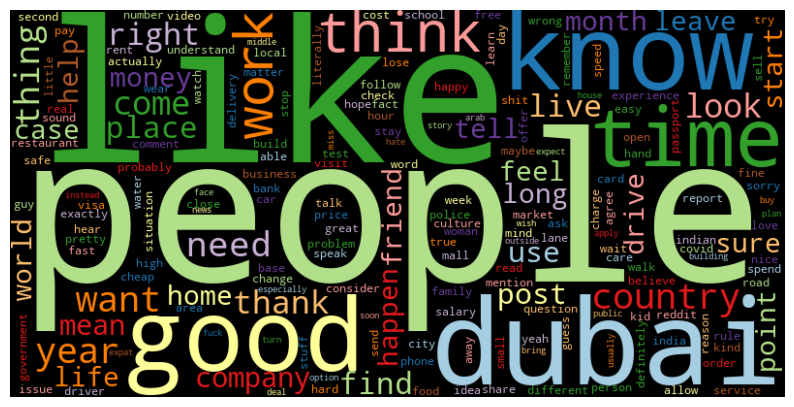

In [26]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
#create custom stop words list
custom_sw = rare_words + common_words #create list holding common and rare words
custom_sw = set(custom_sw) #remove any duplicates

len(custom_sw)

30725

In [32]:
#remove custom stop words from dataset
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word for word in text.split() if word not in custom_sw]))

data.sample(n=5)                                    

,text_type,ID,date_created,year,long_text,clean_text
16237,comment,jjjpmmd,2023-05-10 05:13:35,2023,I need to buy something at-least,
119447,comment,h7vbf4f,2021-08-06 03:15:12,2021,Nice. Any chance for YouTube link please?,chance youtube link
60884,comment,ivsziio,2022-11-10 15:43:53,2022,Staring at this comment . Staring at my userna...,stare stare username stare stare username
92467,comment,hukol3k,2022-01-28 16:27:26,2022,IMPZ(Production City) is thinking which road t...,impz production thinking
20610,comment,gn1m9p4,2021-02-12 14:12:15,2021,Bahahahahaha. I'm not a very confrontational p...,confrontational normally sit rant later note s...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>k. remove extra whitespaces</b></h3>
</span> 

In [33]:
data['clean_text'] = data['clean_text'].str.strip().str.replace(r'\s+', ' ', regex = True)

sample_rows = [5786,18460, 103391]

data.loc[sample_rows]

,text_type,ID,date_created,year,long_text,clean_text
5786,comment,j8mroan,2023-02-15 17:37:07,2023,Confirmed; it’s true. Just need to have the ac...,confirm true account link car plate
18460,comment,hzk2ggz,2022-03-06 12:55:36,2022,Encourage pointless posts on Reddit,encourage pointless reddit
103391,comment,j7zocx9,2023-02-10 19:39:10,2023,I really want this to happen. Especially repla...,especially replace write shitty content spelli...


<span style="color: red; font-family: Calibri Light;">
  <h3><b>l. word tokenization</b></h3>
</span>

In [34]:
start_time = time.time()

data['tokens'] = data['clean_text'].apply(lambda text: word_tokenize(text))

print (f"This code block took {(time.time() - start_time)/60 :.2f} minutes to complete")

data.iloc[rows_to_check].head()

This code block took 0.24 minutes to complete


,text_type,ID,date_created,year,long_text,clean_text,tokens
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,,[]
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",immigration canada australia hello recently in...,"[immigration, canada, australia, hello, recent..."
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,reach grocery normally ignore allow support be...,"[reach, grocery, normally, ignore, allow, supp..."
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,plan spend holiday activity trip line away cur...,"[plan, spend, holiday, activity, trip, line, a..."
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",currently job temporary permanent license than...,"[currently, job, temporary, permanent, license..."


<span style="color: red; font-family: Calibri Light;">
  <h3><b>m. insert word count</b></h3>
</span>

In [35]:
data['word_count'] = data['tokens'].apply (lambda tokens_list: len(tokens_list))

data.sort_values(by='word_count', ascending = False).head()

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",immigration canada australia hello recently in...,"[immigration, canada, australia, hello, recent...",899
125384,submission,jh5hjq,2020-10-24 12:29:05,2020,List of discounts and working promo codes in D...,list discount working promo code hello list di...,"[list, discount, working, promo, code, hello, ...",610
5756,comment,ji1smg1,2023-04-28 17:10:21,2023,"FULLTEXT\nApr 27, 2023\n\nStand in the middle ...",stand middle meena bazaar hard imagine mile ar...,"[stand, middle, meena, bazaar, hard, imagine, ...",477
18342,comment,jj2t0ih,2023-05-06 15:40:03,2023,"FULL TEXT:\n\nBy Archana Narayanan, Abeer Abu ...",text omar bloomberg gamble industry bet united...,"[text, omar, bloomberg, gamble, industry, bet,...",438
109128,comment,fpg1e6j,2020-05-04 15:19:38,2020,Here is the text for those that can’t get by t...,text paywall recent article broker certainly c...,"[text, paywall, recent, article, broker, certa...",417


<span style="color: red; font-family: Calibri Light;">
  <h3><b>n. remove subset for manual labelling</b></h3>
</span>

In [36]:
#load list of sample_subset indices

#sampling done previously by randomly selecting entries from each year

with open('../../../Data/sample_subset_index.txt', 'r') as file:
    subset_ids = [line.strip() for line in file]

subset_ids[:5]

['hbbcq6z', 'hjjhl9r', 'h7ntxws', 'h02sz1n', 'hnuysoa']

In [37]:
#create unlabelled sample subset 
subset_data = data[data['ID'].isin(subset_ids)]
subset_data.head()

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
233,comment,ewm2xjg,2019-08-11 20:46:18,2019,"Except for some of the specific details, this ...",specific detail describe feeling perfectly for...,"[specific, detail, describe, feeling, perfectl...",53
267,comment,fb68ezr,2019-12-17 04:52:52,2019,It's so touching to see bromance develop betwe...,develop,[develop],1
279,comment,ewm7kp0,2019-08-11 21:37:06,2019,*Most* Indians have degrees in computer scienc...,indians degree computer science adult indian p...,"[indians, degree, computer, science, adult, in...",11
755,comment,josli8t,2023-06-20 08:35:18,2023,Wow. That's very interesting to know. Thanks ...,interesting,[interesting],1
771,comment,josux9n,2023-06-20 10:28:16,2023,Currently it’s gonna cost around 70K per annum...,currently annum bayut property finder,"[currently, annum, bayut, property, finder]",5


In [38]:
#get index of entries in sampled subset
subset_index = data[data['ID'].isin(subset_ids)].index.to_list()

#remove sample subset from data

training_data = data.drop(subset_index, axis = 0)


training_data.head()

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*",cuntry,[cuntry],1
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi...",send cuntry,"[send, cuntry]",2
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...,single travel cuntry past,"[single, travel, cuntry, past]",4
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...,shop dragon mart,"[shop, dragon, mart]",3
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅,,[],0


In [39]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127683 entries, 0 to 128882
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   text_type     127683 non-null  object        
 1   ID            127683 non-null  object        
 2   date_created  127683 non-null  datetime64[ns]
 3   year          127683 non-null  int64         
 4   long_text     127683 non-null  object        
 5   clean_text    127683 non-null  object        
 6   tokens        127683 non-null  object        
 7   word_count    127683 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 8.8+ MB


<span style="color: red; font-family: Calibri Light;">
  <h3><b>o. remove short entries</b></h3>
</span>

In [40]:
#select only rows with more than 3 word
lda_training = training_data[training_data['word_count'] > 3]

lda_training.shape

(61376, 8)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>p. save training dataset for LDAModel</b></h3>
</span>

In [41]:
#save data
filename = '../../../Data/lda_train.csv'

def export_csv():
    '''
    export pre-processed data to CSV
    '''
    lda_training.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)

export_csv()

print ('file saved')

file saved


---

<span style="color: red; font-family: Calibri Light;">
  <h2><b>IV. Feature Extraction</b></h2>
</span>

<span style="color: red; font-family: Calibri Light;">
  <h3><b>a. create corpus & dictionary</b></h3>
</span>

In [68]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


lda_data = pd.read_csv('../../../Data/lda_train.csv', converters ={'tokens':list_converter})
lda_data = lda_data.drop(columns = ['index'])
lda_data.sort_values(by='date_created', inplace = True)
lda_data.head()

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
48523,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,stare picture second miss,"[stare, picture, second, miss]",4
48521,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...",sister subreddit mildly interesting chance eve...,"[sister, subreddit, mildly, interesting, chanc...",18
48522,comment,c6d46es,2012-09-25 12:32:08,2012,common give prince william harry a break he ju...,common prince harry break,"[common, prince, harry, break]",4
60652,submission,1sur9h,2013-12-14 11:02:08,2013,Took this image of the Burj Khalifa from Souk ...,image burj khalifa souk bahar yesterday build ...,"[image, burj, khalifa, souk, bahar, yesterday,...",11
37629,comment,ce1gf68,2013-12-14 12:07:24,2013,"Sorry pal, but you took an artistically not-so...",sorry impressive photo landmark resident karma...,"[sorry, impressive, photo, landmark, resident,...",8


In [69]:
lda_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61376 entries, 48523 to 47527
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     61376 non-null  object
 1   ID            61376 non-null  object
 2   date_created  61376 non-null  object
 3   year          61376 non-null  int64 
 4   long_text     61376 non-null  object
 5   clean_text    61376 non-null  object
 6   tokens        61376 non-null  object
 7   word_count    61376 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.2+ MB


In [70]:
#convert df['tokens'] to list of strings for bag-of-words model
docs = lda_data['tokens'].tolist()

In [71]:
print(docs[:5])

[['stare', 'picture', 'second', 'miss'], ['sister', 'subreddit', 'mildly', 'interesting', 'chance', 'event', 'thread', 'possible', 'odd', 'subscriber', 'active', 'small', 'subreddit', 'florida', 'connection', 'prior', 'arrival', 'desire'], ['common', 'prince', 'harry', 'break'], ['image', 'burj', 'khalifa', 'souk', 'bahar', 'yesterday', 'build', 'goddamn', 'tall', 'phone', 'option'], ['sorry', 'impressive', 'photo', 'landmark', 'resident', 'karma', 'material', 'upvote']]


In [72]:
#check number of unique words

unique_words = set([word for text in docs for word in text])

print (f'There are {len(unique_words)} unique words in the dataset')


There are 7993 unique words in the dataset


In [73]:
# Create bigrams - code from gensim documentation page
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [75]:
print(docs[3])

['image', 'burj', 'khalifa', 'souk', 'bahar', 'yesterday', 'build', 'goddamn', 'tall', 'phone', 'option', 'burj_khalifa']


In [76]:
#code from gensim bag of words documentation page

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
#dictionary.filter_extremes(no_below= 10, no_above=0.50)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8315
Number of documents: 61376


<span style="color: red; font-family: Calibri Light;">
  <h3><b>b. create tfidf representation</b></h3>
</span>

In [77]:
tfidf = TfidfModel (corpus)
tfidf_corpus = tfidf[corpus]

<span style="color: red; font-family: Calibri Light;">
  <h3><b>c. Load Word2Vec embeddings</b></h3>
</span>
<p>This embeddings were created in the lda_model notebook, and trained on the whole data i.e comments & submissions</p>

In [78]:
w2v_model = Word2Vec.load('../models/w2v_model_lda_bigrams.model')

In [79]:
num_unique_words = len(w2v_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")


Number of unique words in the vocabulary: 8315


In [80]:
terms_check = ['lulu', 'reddit', 'parent', 'brown', 'metro', 'employee', 'noon', 'summer', 'mosque', 'lgbt', 'golden', 'mall']

for word in terms_check:
    print (w2v_model.wv.most_similar (word))

[('carrefour', 0.9776630997657776), ('souq', 0.9745427370071411), ('fruit', 0.962378203868866), ('supermarket', 0.960110604763031), ('veggie', 0.9575585126876831), ('mcdonald', 0.9574557542800903), ('vegetable', 0.9561629891395569), ('waitrose', 0.9526785016059875), ('spinney', 0.9508016705513), ('cafeteria', 0.9480945467948914)]
[('subreddit', 0.9445328712463379), ('mod', 0.9165140986442566), ('delete', 0.9000437259674072), ('ban', 0.8900930881500244), ('downvote', 0.8823402523994446), ('content', 0.8599086403846741), ('conversation', 0.8541792035102844), ('reply', 0.8525258898735046), ('moderator', 0.8363224864006042), ('upvote', 0.8341659903526306)]
[('child', 0.960465133190155), ('kid', 0.9240392446517944), ('wife', 0.918626606464386), ('father', 0.9070699214935303), ('young', 0.9064603447914124), ('husband', 0.8956191539764404), ('mother', 0.8904939293861389), ('daughter', 0.8889415264129639), ('brother', 0.8689917325973511), ('adult', 0.8598188161849976)]
[('color', 0.94984000921

---

<span style="color: red; font-family: Calibri Light;">
  <h2><b>V. TRAIN MODEL</b></h2>
</span>

In [81]:
#from gensim documentation at https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?expand_article=1#9createbigramandtrigrammodels
#https://github.com/clevyclev/Deep-Learning-Projects/blob/master/Latent%20Dirichlet%20Allocation%20-%20Bag%20of%20Words%20and%20TF-IDF/Latent_dirichlet_allocation.py

#training parameters
chunksize = 5000
passes = 10
iterations = 400
eval_every = None
id2word = dictionary.id2token
temp = dictionary[0] #to "load" the dictionary

#range of topics
topics_range = [5,10,15,20,25,50]

# Lists to hold metrics
model_coherence_cv = []
#model_coherence_umass = []
model_coherence_cnpmi = []
model_perplexity = []
topic_diversity = []

start_time = time.time()
for num_topics in topics_range:
    
    # Train LDA model
    lda_model = LdaModel(corpus=tfidf_corpus,
                         id2word=dictionary,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         passes=passes,
                         iterations=iterations,
                         num_topics=num_topics,
                         per_word_topics=True,
                         random_state=80)
    
    # Compute c_v score
    c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    cv_lda = c_v.get_coherence()
    model_coherence_cv.append(cv_lda)
    
    # Compute u_mass score
    #u_mass = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
    #umass_lda = u_mass.get_coherence()
    #model_coherence_umass.append(umass_lda)
    
    # Compute c_npmi score
    c_npmi = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
    cnpmi_lda = c_npmi.get_coherence()
    model_coherence_cnpmi.append(cnpmi_lda)
    
    # Compute perplexity
    perplexity = lda_model.log_perplexity(tfidf_corpus)
    model_perplexity.append(perplexity)
    
    # Compute topic diversity
    top_n = 10
    top_words = [word for topic_id in range(num_topics) for word, _ in lda_model.show_topic(topic_id, topn=top_n)]
    diversity = len(set(top_words)) / (num_topics * top_n)
    topic_diversity.append(diversity)
    
    print(f"For {num_topics} topics: Coherence(c_v) = {cv_lda},Coherence(c_npmi) = {cnpmi_lda}, Perplexity = {perplexity}, Topic Diversity = {diversity}")

print(f"This model took {(time.time() - start_time)/60 :.2f} minutes to train")

For 5 topics: Coherence(c_v) = 0.5524931639826093,Coherence(c_npmi) = -0.2275055725089489, Perplexity = -8.601086408248953, Topic Diversity = 1.0
For 10 topics: Coherence(c_v) = 0.4643241706733686,Coherence(c_npmi) = -0.2408756141184957, Perplexity = -8.810146978482967, Topic Diversity = 1.0
For 15 topics: Coherence(c_v) = 0.47829998518216565,Coherence(c_npmi) = -0.2359920493210464, Perplexity = -9.735345652939262, Topic Diversity = 1.0
For 20 topics: Coherence(c_v) = 0.49657261452308754,Coherence(c_npmi) = -0.25018024335694644, Perplexity = -10.211707278530723, Topic Diversity = 1.0
For 25 topics: Coherence(c_v) = 0.4585007463475387,Coherence(c_npmi) = -0.2824555728577682, Perplexity = -10.720248880168592, Topic Diversity = 1.0
For 50 topics: Coherence(c_v) = 0.3739766495450725,Coherence(c_npmi) = -0.2365525790548288, Perplexity = -16.847532680112288, Topic Diversity = 1.0
This model took 17.64 minutes to train


In [82]:
evals = {'topics': topics_range,'coherence(c_v)': model_coherence_cv, 'coherence(c_npmi)':model_coherence_cnpmi, 'perplexity':model_perplexity, 'topic_diversity': topic_diversity}
model_eval = pd.DataFrame(evals)

model_eval.to_csv('lda_tfidf_evals.csv')

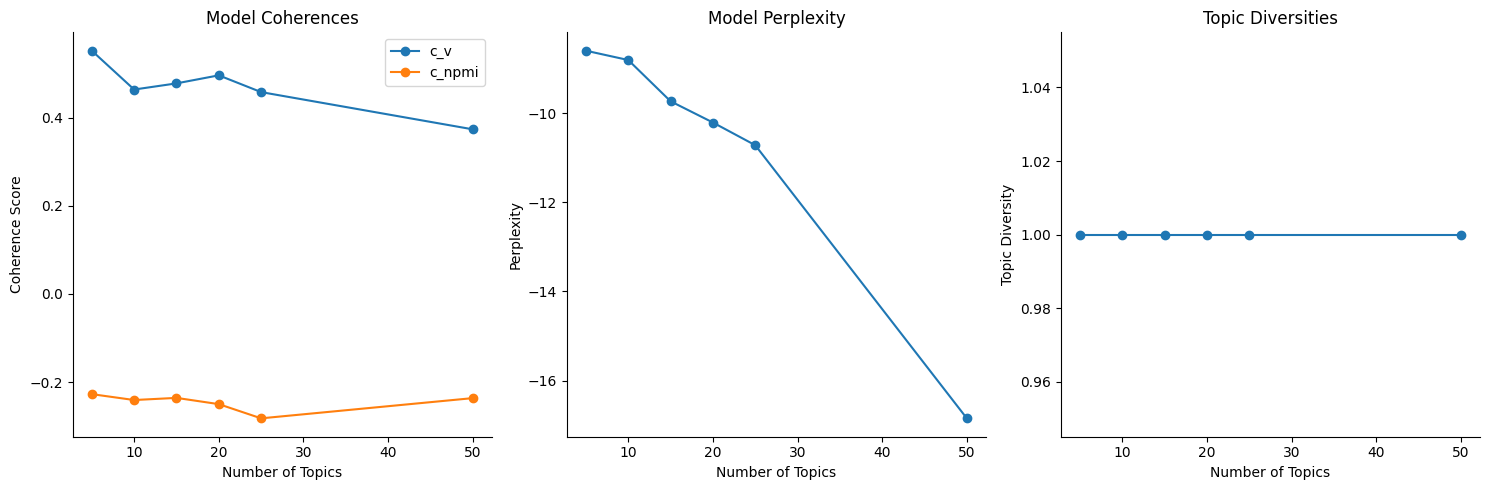

In [83]:
#Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Plot model coherences
axes[0].plot(topics_range, model_coherence_cv, marker='o', label='c_v')
axes[0].plot(topics_range, model_coherence_cnpmi, marker='o', label='c_npmi')
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('Coherence Score')
axes[0].legend()
axes[0].set_title('Model Coherences')

#Plot model perplexity
axes[1].plot(topics_range, model_perplexity, marker='o')
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Model Perplexity')

#Plot topic diversities
axes[2].plot(topics_range, topic_diversity, marker='o')
axes[2].set_xlabel('Number of Topics')
axes[2].set_ylabel('Topic Diversity')
axes[2].set_title('Topic Diversities')

#Remove right and top borders for each plot
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('lda_metrics_tfidf_plots.png')
plt.show()


<p>The evaluation metrics used all point to 5 as the optimal number of topics. 
We will now visually inspect the output of each proposed model, and using our word2vec model, 
we will check the average similarity of the top 10 words in each topic of each proposed model</p>

<span style="color: red; font-family: Calibri Light;">
  <h3><b>define function to train, evaluate and visualize the models</b></h3>
</span>

In [84]:
params = {
    'alpha': 'auto',
    'eta': 'auto',
    'chunksize': 5000,
    'passes': 10,
    'iterations': 400,
    'eval_every': None
}

In [85]:
#function to train model
def train_model(num_topics, random_state, corpus, id2word, **kwargs):
    temp = dictionary[0]
    lda_model = LdaModel(num_topics= num_topics, random_state = random_state, corpus = corpus, id2word = id2word, **kwargs)
    
    return lda_model

#function to compute coherence, diversity and perplexity metrics
def eval_metrics (lda_model, docs, dictionary, num_topics, top_n = 10):
    #Compute c_v score
    c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    cv_lda = c_v.get_coherence()
    
    # Compute u_mass score
    u_mass = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
    umass_lda = u_mass.get_coherence()
    
    # Compute c_npmi score
    c_npmi = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
    cnpmi_lda = c_npmi.get_coherence()
    
    # Compute perplexity
    perplexity = lda_model.log_perplexity(corpus)
    
    # Compute topic diversity
    top_words = [word for topic_id in range(num_topics) for word, _ in lda_model.show_topic(topic_id, topn=top_n)]
    diversity = len(set(top_words)) / (num_topics * top_n)
    
    return cv_lda, umass_lda, cnpmi_lda, perplexity, diversity

#function to check average word similarities for the topics 
def average_similarity(lda_model, num_topics, w2v_model, top_n=10):
    #extract top 10 words for each topic
    top_words_per_topic =[] 
    for topic_id in range(num_topics):
        top_words = lda_model.show_topic(topic_id, topn=top_n)
        top_words = [word for word, _ in top_words]
        top_words_per_topic.append(top_words)
        
    # 2. Compute pairwise similarities for each topic
    average_similarities = []
    for top_words in top_words_per_topic:
        total_similarity = 0
        count = 0
        for i in range(len(top_words)):
            for j in range(i+1, len(top_words)):  # Compare each word with the words after it
                if top_words[i] in w2v_model.wv and top_words[j] in w2v_model.wv:
                    similarity = w2v_model.wv.similarity(top_words[i], top_words[j])
                    total_similarity += similarity
                    count += 1
        average_similarity = total_similarity / count if count != 0 else 0
        average_similarities.append(average_similarity)
        
    return average_similarities

#function to create bar charts of the top_n words of the topics
def plot_topic_barchat(lda_model, top_n=10):
    num_topics = lda_model.num_topics
    cols = int(np.ceil(num_topics ** 0.5))  # Square root to decide number of columns
    rows = int(np.ceil(num_topics / cols))  # Calculate rows based on columns
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    
    # If only one topic, axes is not an array
    if num_topics == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    for topic_num in range(num_topics):
        top_words = lda_model.show_topic(topic_num, topn=top_n)
        topic_words, probs = zip(*top_words)
        
        sns.barplot(x=probs, y=topic_words, ax=axes[topic_num], palette='viridis')
        axes[topic_num].set_title(f'Topic {topic_num}')
        axes[topic_num].set_xlabel('Probability')
    
    # Remove any remaining empty subplots
    for i in range(num_topics, rows*cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle('Top Words for Each Topic', y=1.02, fontsize=16)
    plt.show()

In [86]:
def train_model_vis_check_similarity (num_topics, random_state, corpus,dictionary,w2v_model, top_n, docs, **kwargs):
    lda_model = train_model(num_topics=num_topics, random_state=random_state, corpus=corpus, id2word=dictionary.id2token, **kwargs)
    cv_lda, umass_lda, cnpmi_lda, perplexity, diversity = eval_metrics (lda_model, docs, dictionary, num_topics, top_n)
    average_similarities  = average_similarity(lda_model, num_topics, w2v_model, top_n)
    
    print(f"For {num_topics} topics:\nCoherence(c_v) = {cv_lda},\nCoherence(c_npmi) = {cnpmi_lda},\nCoherence(u_mass) = {umass_lda},\nPerplexity = {perplexity},\nTopic Diversity = {diversity}\n")
    
    return lda_model, average_similarities

<span style="color: red; font-family: Calibri Light;">
  <h3><b>a. model 1: 5 topics</b></h3>
</span>

In [87]:
model_1, avg_sims1 = train_model_vis_check_similarity(num_topics = 5, random_state = 5, 
                                                      w2v_model = w2v_model,
                                                      corpus = tfidf_corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims1):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 5 topics:
Coherence(c_v) = 0.45886877317210945,
Coherence(c_npmi) = -0.14244930574814046,
Coherence(u_mass) = -8.043528743250175,
Perplexity = -8.210661697165532,
Topic Diversity = 1.0

Average similarity for topic 0: 0.4529
Average similarity for topic 1: 0.5046
Average similarity for topic 2: 0.4277
Average similarity for topic 3: 0.3876
Average similarity for topic 4: 0.3203


In [88]:
#save model
model_1.save('../models/model_1_tfidf_5tpcs/lda_model_1_5tpcs')

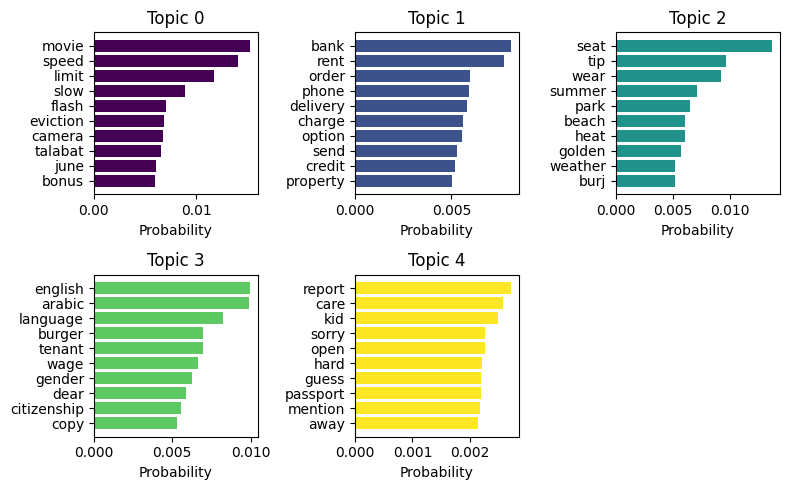

In [89]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#number of topics
num_topics = model_1.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 2
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(8,5))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_1.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [90]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_1, tfidf_corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>b. model 2: 10 topics</b></h3>
</span>

In [91]:
model_2, avg_sims2 = train_model_vis_check_similarity(num_topics = 10, random_state = 10, 
                                                      w2v_model = w2v_model,
                                                      corpus = tfidf_corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims2):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 10 topics:
Coherence(c_v) = 0.408702646642645,
Coherence(c_npmi) = -0.18363496434858706,
Coherence(u_mass) = -9.637791350836771,
Perplexity = -8.28632834051269,
Topic Diversity = 1.0

Average similarity for topic 0: 0.5867
Average similarity for topic 1: 0.6853
Average similarity for topic 2: 0.2347
Average similarity for topic 3: 0.6428
Average similarity for topic 4: 0.4427
Average similarity for topic 5: 0.4284
Average similarity for topic 6: 0.4040
Average similarity for topic 7: 0.5363
Average similarity for topic 8: 0.3808
Average similarity for topic 9: 0.5389


In [92]:
#save model
model_2.save('../models/model_2_tfidf_10tpcs/lda_model_2_10tpcs')

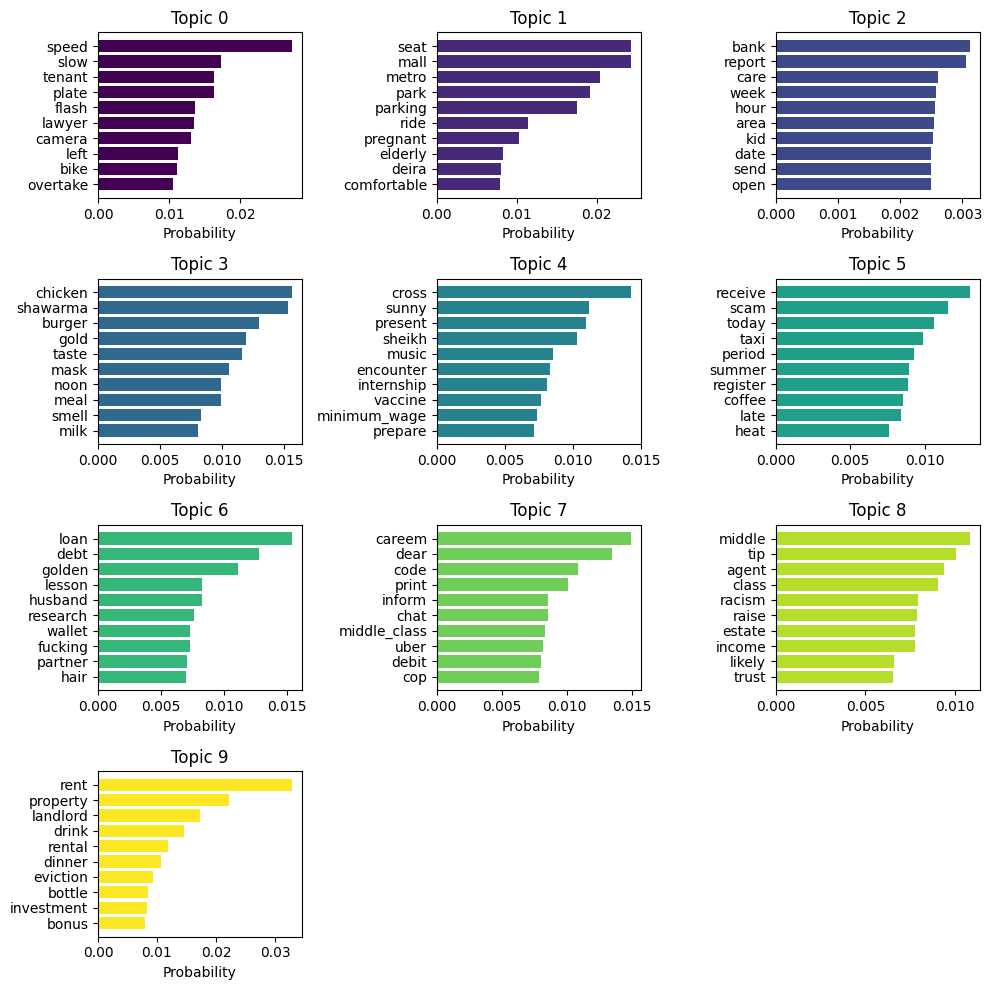

In [93]:

#visualize the topics in a barchart
#number of topics
num_topics = model_2.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 4
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(10,10))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_2.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [94]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_2, tfidf_corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>c. model 3: 15 topics</b></h3>
</span>

In [95]:
model_3, avg_sims3 = train_model_vis_check_similarity(num_topics = 15, random_state = 15, 
                                                      w2v_model = w2v_model,
                                                      corpus = tfidf_corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims3):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 15 topics:
Coherence(c_v) = 0.4176584633958006,
Coherence(c_npmi) = -0.20113320749437016,
Coherence(u_mass) = -9.776368136103766,
Perplexity = -8.882032149441699,
Topic Diversity = 1.0

Average similarity for topic 0: 0.3740
Average similarity for topic 1: 0.4258
Average similarity for topic 2: 0.2777
Average similarity for topic 3: 0.5564
Average similarity for topic 4: 0.4292
Average similarity for topic 5: 0.6881
Average similarity for topic 6: 0.4357
Average similarity for topic 7: 0.5068
Average similarity for topic 8: 0.5169
Average similarity for topic 9: 0.2181
Average similarity for topic 10: 0.3282
Average similarity for topic 11: 0.4763
Average similarity for topic 12: 0.4211
Average similarity for topic 13: 0.5258
Average similarity for topic 14: 0.3097


In [96]:
#save model
model_3.save('../models/model_3_tfidf_15tpcs/lda_model_3_15tpcs')

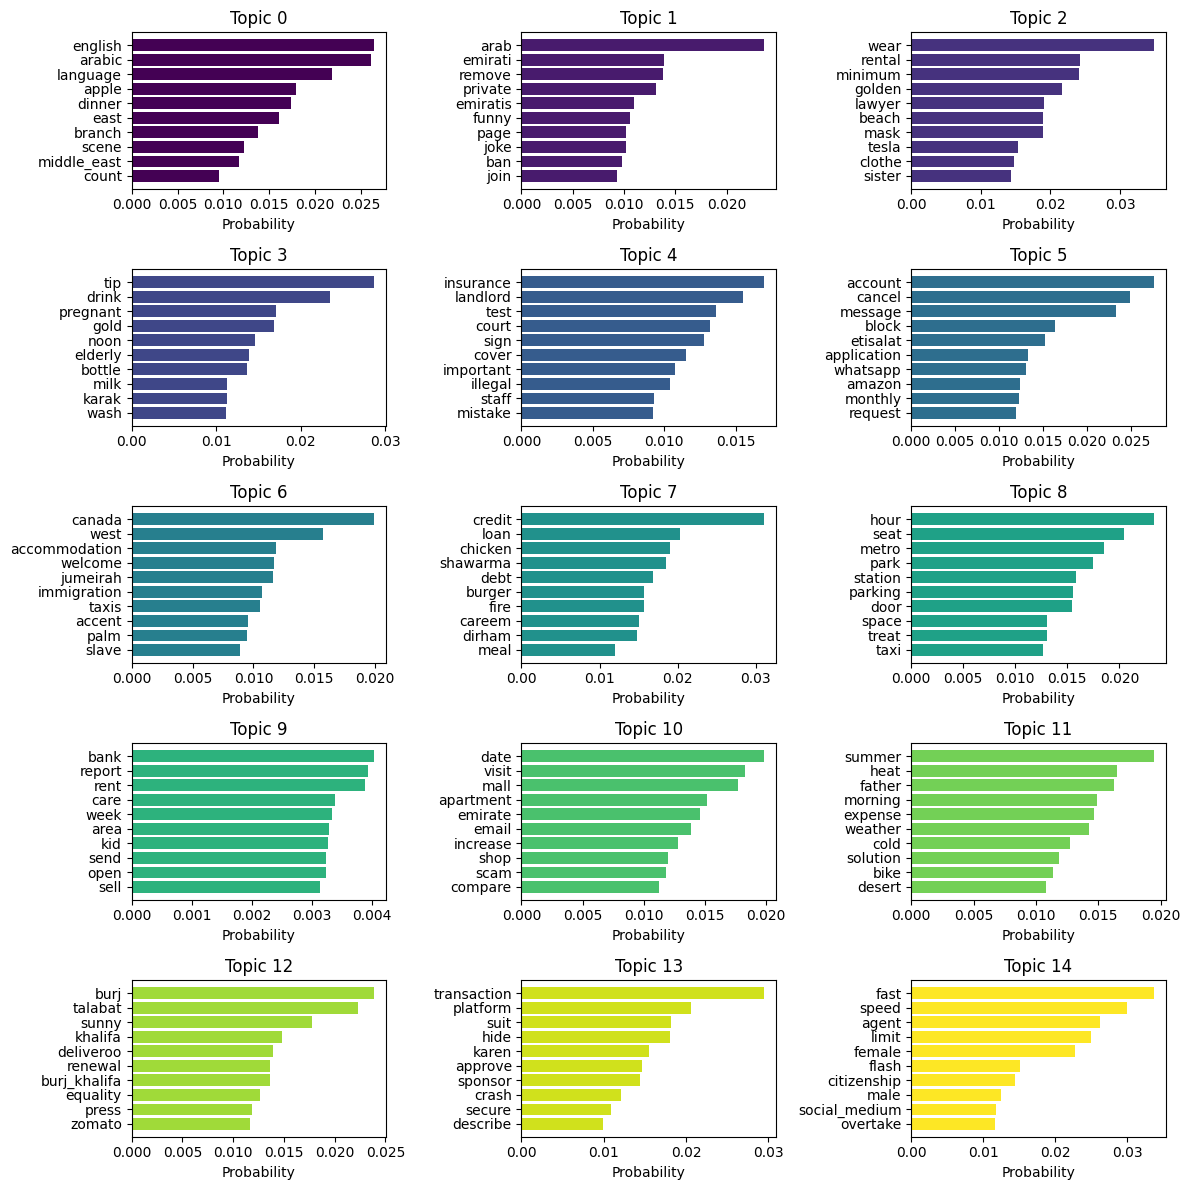

In [97]:

#visualize the topics in a barchart
#number of topics
num_topics = model_3.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 5
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(12,12))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_3.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [98]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_3, tfidf_corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>d. model 4: 20 topics</b></h3>
</span>

In [99]:
model_4, avg_sims4 = train_model_vis_check_similarity(num_topics = 20, random_state = 20, 
                                                      w2v_model = w2v_model,
                                                      corpus = tfidf_corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims4):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 20 topics:
Coherence(c_v) = 0.3965444574338076,
Coherence(c_npmi) = -0.25189286277159306,
Coherence(u_mass) = -10.562387829019347,
Perplexity = -9.150254141136626,
Topic Diversity = 1.0

Average similarity for topic 0: 0.3438
Average similarity for topic 1: 0.5796
Average similarity for topic 2: 0.4041
Average similarity for topic 3: 0.2741
Average similarity for topic 4: 0.4020
Average similarity for topic 5: 0.4592
Average similarity for topic 6: 0.4934
Average similarity for topic 7: 0.4992
Average similarity for topic 8: 0.4808
Average similarity for topic 9: 0.6075
Average similarity for topic 10: 0.4358
Average similarity for topic 11: 0.3268
Average similarity for topic 12: 0.4629
Average similarity for topic 13: 0.4196
Average similarity for topic 14: 0.4804
Average similarity for topic 15: 0.5689
Average similarity for topic 16: 0.4648
Average similarity for topic 17: 0.2334
Average similarity for topic 18: 0.4851
Average similarity for topic 19: 0.3850


In [100]:
#save model
model_4.save('../models/model_4_tfidf_20tpcs/lda_model_4_20tpcs')

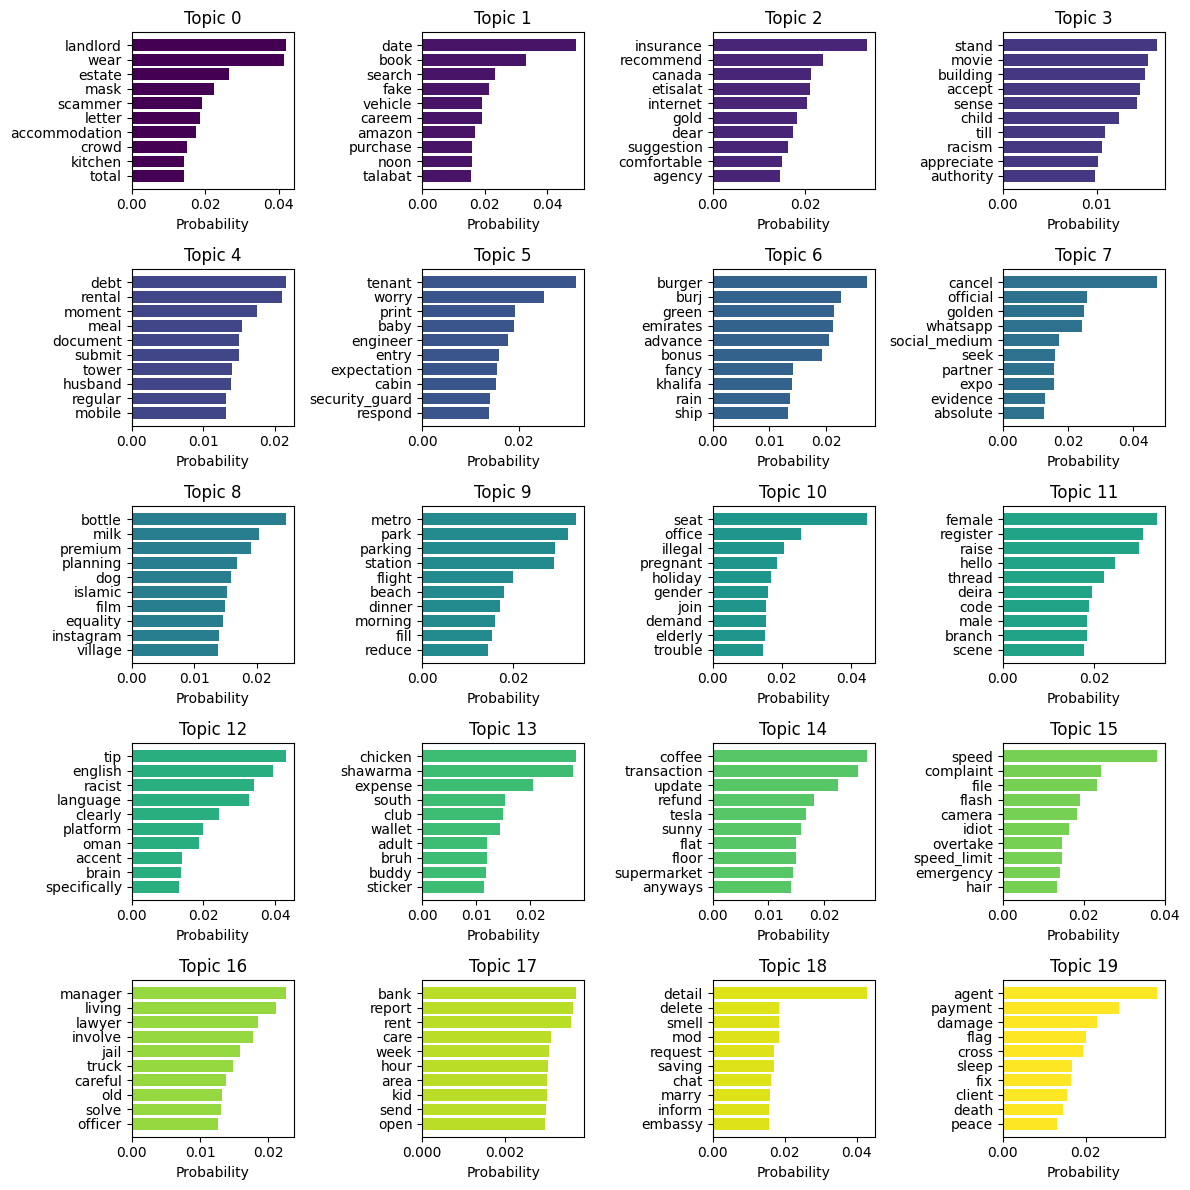

In [101]:

#visualize the topics in a barchart
#number of topics
num_topics = model_4.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 5
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(12,12))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_4.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [102]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_4, tfidf_corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>e. model 5: 25 topics</b></h3>
</span>

In [103]:
model_5, avg_sims5 = train_model_vis_check_similarity(num_topics = 25, random_state = 25, 
                                                      w2v_model = w2v_model,
                                                      corpus = tfidf_corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims5):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 25 topics:
Coherence(c_v) = 0.4340934963015921,
Coherence(c_npmi) = -0.2553792151858114,
Coherence(u_mass) = -10.925604512477992,
Perplexity = -9.421368369992248,
Topic Diversity = 1.0

Average similarity for topic 0: 0.5611
Average similarity for topic 1: 0.4534
Average similarity for topic 2: 0.5548
Average similarity for topic 3: 0.6796
Average similarity for topic 4: 0.6287
Average similarity for topic 5: 0.4038
Average similarity for topic 6: 0.5135
Average similarity for topic 7: 0.3382
Average similarity for topic 8: 0.5930
Average similarity for topic 9: 0.5341
Average similarity for topic 10: 0.3573
Average similarity for topic 11: 0.5293
Average similarity for topic 12: 0.4583
Average similarity for topic 13: 0.3932
Average similarity for topic 14: 0.6061
Average similarity for topic 15: 0.2915
Average similarity for topic 16: 0.4215
Average similarity for topic 17: 0.2238
Average similarity for topic 18: 0.3795
Average similarity for topic 19: 0.4778
Average similarity f

In [104]:
#save model
model_5.save('../models/model_5_tfidf_25tpcs/lda_model_5_25tpcs')

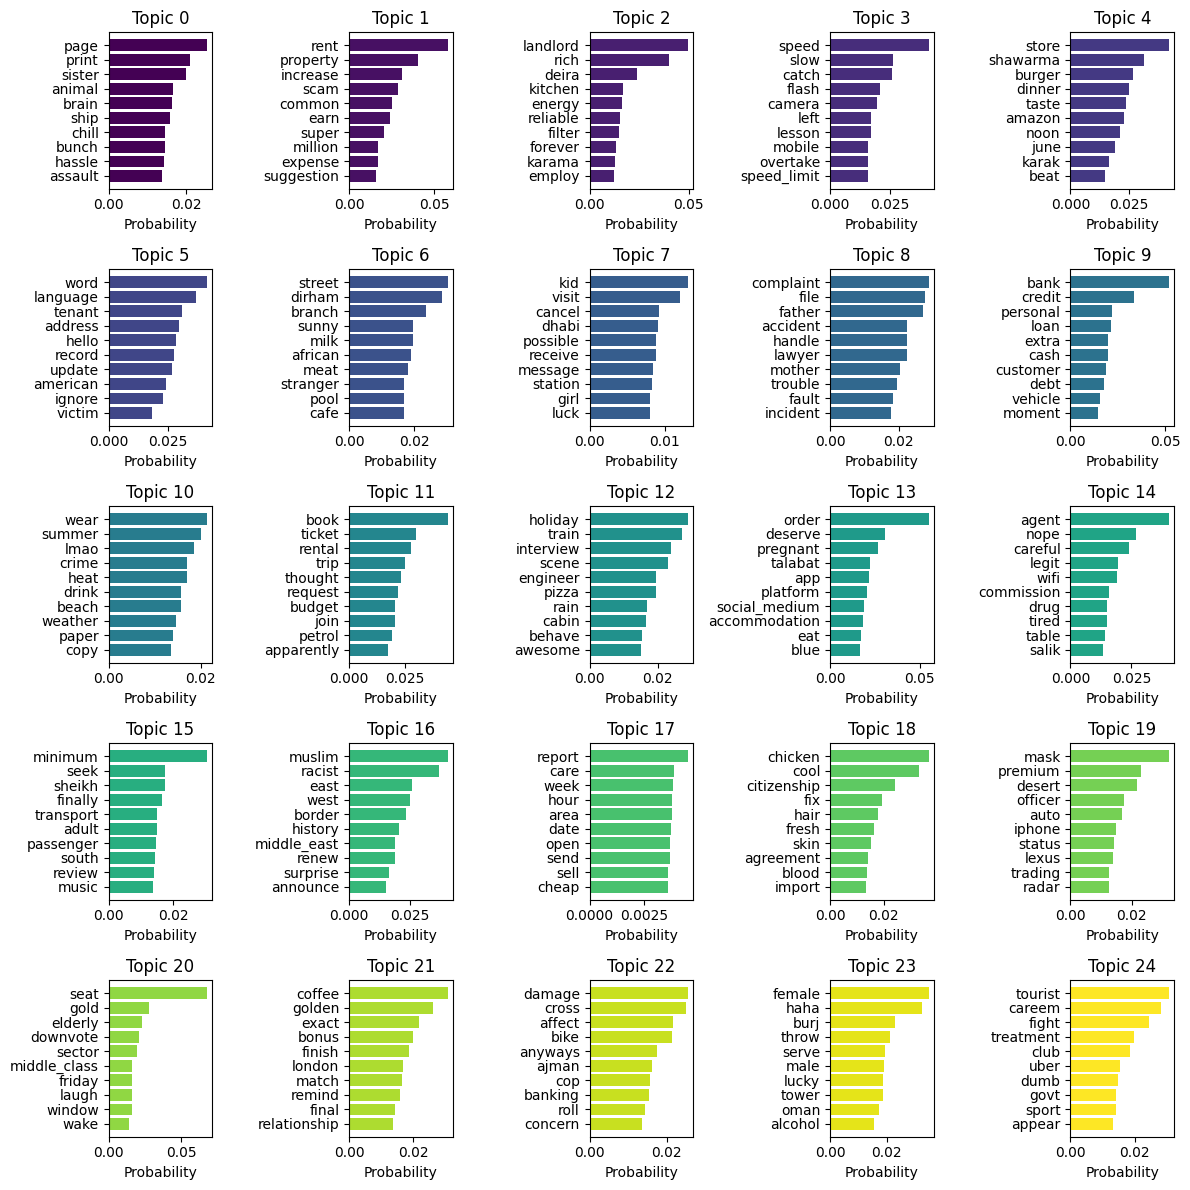

In [105]:

#visualize the topics in a barchart
#number of topics
num_topics = model_5.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 5
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(12,12))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_5.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [106]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_5, tfidf_corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>f. model 6: 50 topics</b></h3>
</span>

In [107]:
model_6, avg_sims6 = train_model_vis_check_similarity(num_topics = 50, random_state = 50, 
                                                      w2v_model = w2v_model,
                                                      corpus = tfidf_corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims6):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 50 topics:
Coherence(c_v) = 0.34378010553671406,
Coherence(c_npmi) = -0.19910606204287412,
Coherence(u_mass) = -8.69539643997857,
Perplexity = -13.245295365923724,
Topic Diversity = 1.0

Average similarity for topic 0: 0.2381
Average similarity for topic 1: 0.3784
Average similarity for topic 2: 0.2894
Average similarity for topic 3: 0.4118
Average similarity for topic 4: 0.4914
Average similarity for topic 5: 0.4361
Average similarity for topic 6: 0.3926
Average similarity for topic 7: 0.5499
Average similarity for topic 8: 0.3898
Average similarity for topic 9: 0.3340
Average similarity for topic 10: 0.5466
Average similarity for topic 11: 0.4283
Average similarity for topic 12: 0.2753
Average similarity for topic 13: 0.4429
Average similarity for topic 14: 0.4341
Average similarity for topic 15: 0.4229
Average similarity for topic 16: 0.4446
Average similarity for topic 17: 0.4007
Average similarity for topic 18: 0.4350
Average similarity for topic 19: 0.3617
Average similarity 

In [108]:
#save model
model_6.save('../models/model_6_tfidf_50tpcs/lda_model_6_50tpcs')

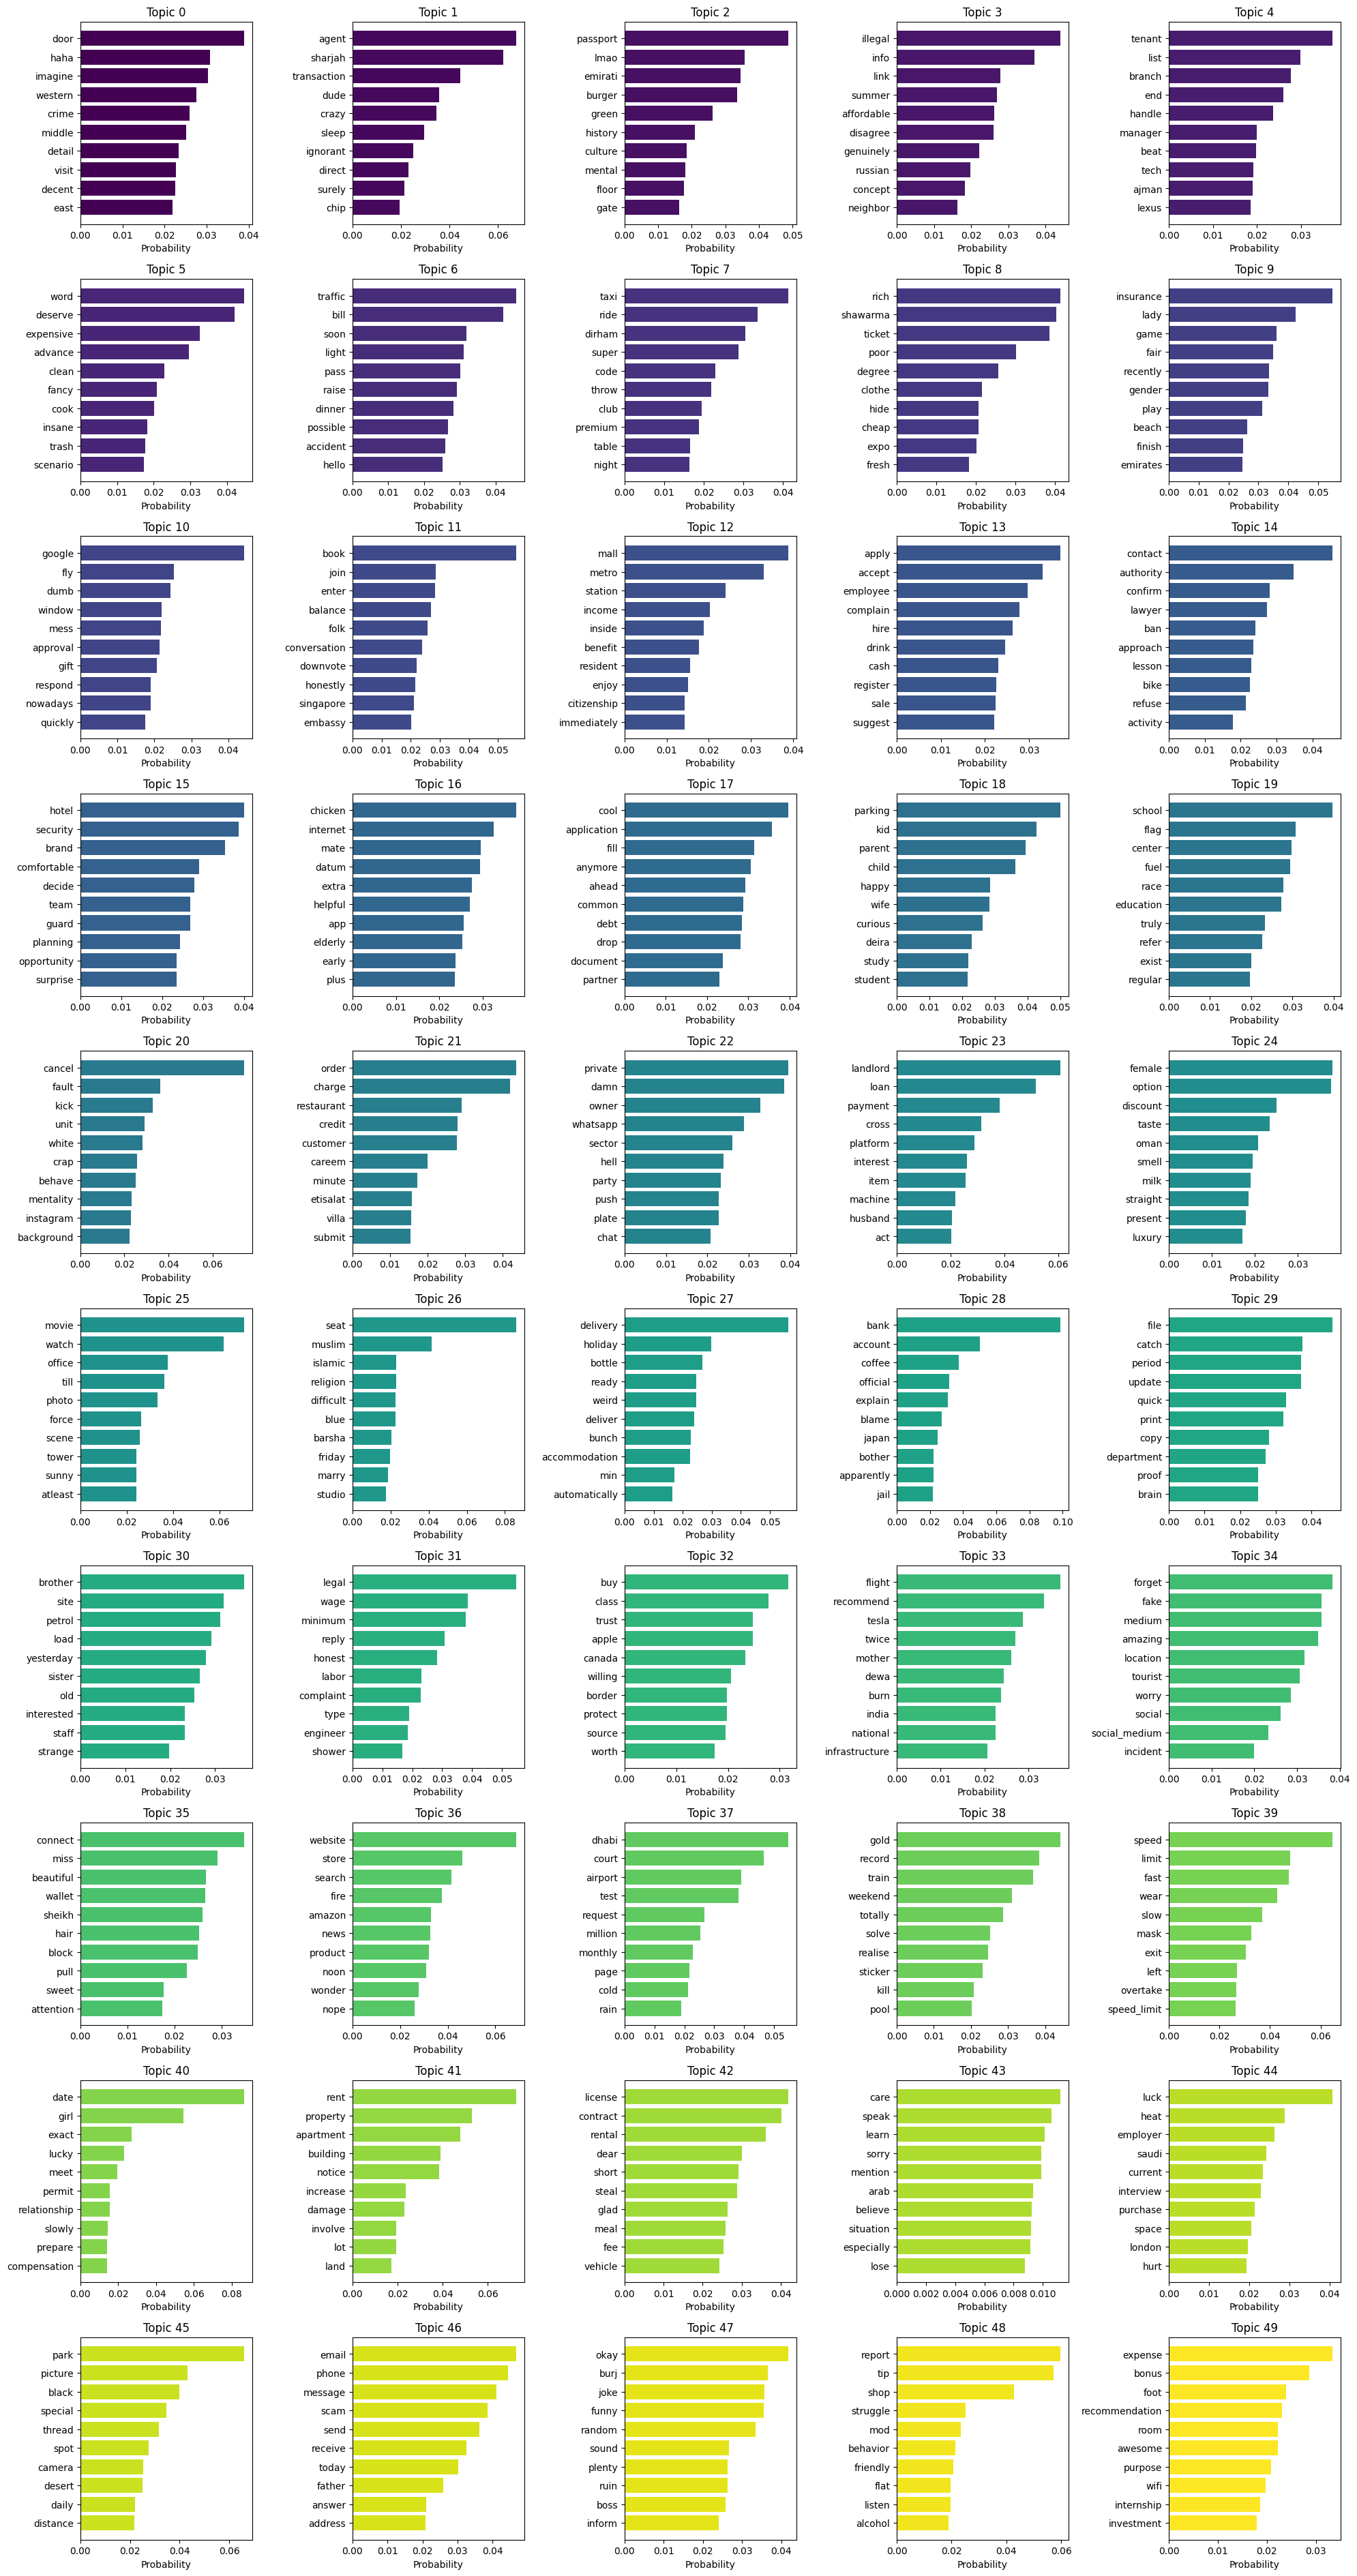

In [109]:

#visualize the topics in a barchart
#number of topics
num_topics = model_6.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 12
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(20,45))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_6.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [110]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_6, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

---